# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [5]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        # Инициализация вектора весов нулями если начальное приближение не задано
        if self.w0 is None:
          self.w0 = np.zeros(X.shape[1])

        # Инициализация loss_history
        self.loss_history = []

        # Подсчет нулевого loss, инициализация w
        if self.w is None:
          self.w = self.w0
          loss = self.calc_loss(X, y)
          self.loss_history.append(loss)

          #  Вряд ли когда-либо это сработает, но вдруг начальное приближение будет очень хорошим
          if loss <= self.tolerance:
            return self

        # Цикл градиентного спуска
        for i in range(0, self.max_iter):
          # Полный градиент
          if self.gd_type == 'full':
            w_grad = self.calc_gradient(X, y)
          elif self.gd_type == 'stochastic':
            idx = np.random.randint(0, X.shape[0])
            x_i = X[idx:idx+1, :]
            y_i = y[idx:idx+1]
            w_grad = self.calc_gradient(x_i, y_i)
          # Проверка на евклидовую разность двух соседних весов
          w_new = self.w - self.eta * w_grad
          if np.linalg.norm(self.w - w_new) <= self.tolerance:
            return self

          self.w = w_new
          # Подсчет функции ошибки
          loss = self.calc_loss(X, y)
          self.loss_history.append(loss)
          if loss <= self.tolerance:
            return self

        # Кончились итерации
        return self

    # Предсказание вероятностей
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        # Поиск вероятности того, что i-ый класс - 1 при помощи сигмоиды
        p_proba = 1. / (1 + np.exp(-1 * X@self.w))
        return p_proba

    # Предсказание классов по вероятностям
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        # Предсказание вероятностей того, что i-ый класс - 1
        p_proba = self.predict_proba(X)
        # Сравнение предсказанных вероятностей с порогом и вывод класса
        prediction = (p_proba >= 0.5).astype(int)
        return prediction
    # Вычисление градиента
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        p_proba = self.predict_proba(X)
        w_grad = 1./X.shape[0] * X.T@(p_proba - y)
        return w_grad
    # Вычисление log loss
    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        p_proba = self.predict_proba(X)
        loss0 = np.log(1-p_proba)
        loss1 = np.log(p_proba)
        loss = -1./len(y) * np.sum(y * loss1 + (1-y) * loss0)
        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [4]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

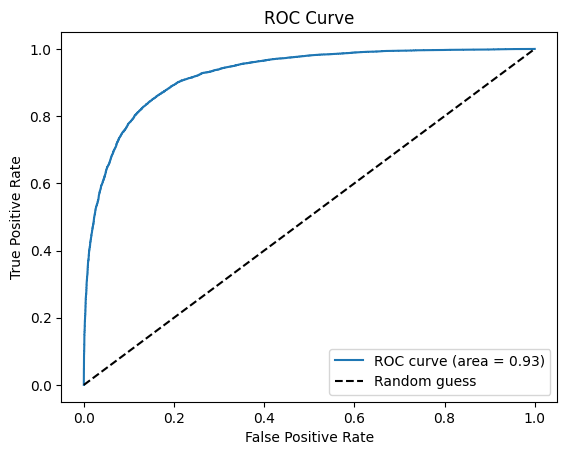

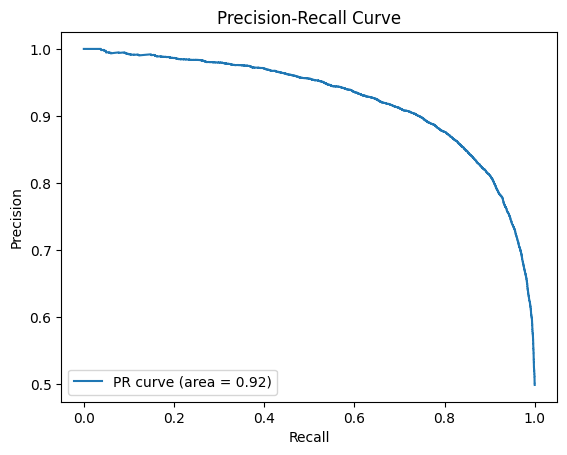

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
logreg = LogReg(gd_type='full',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2)

logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


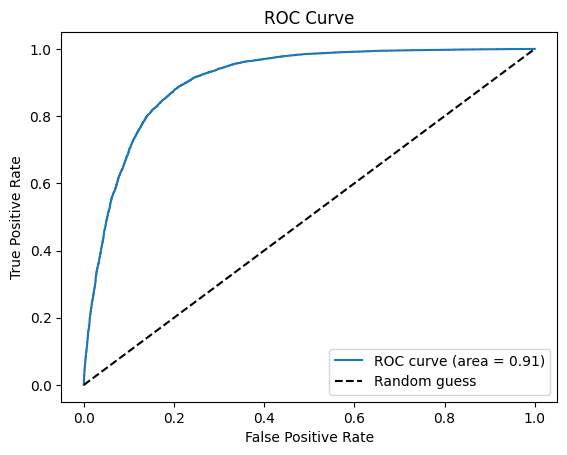

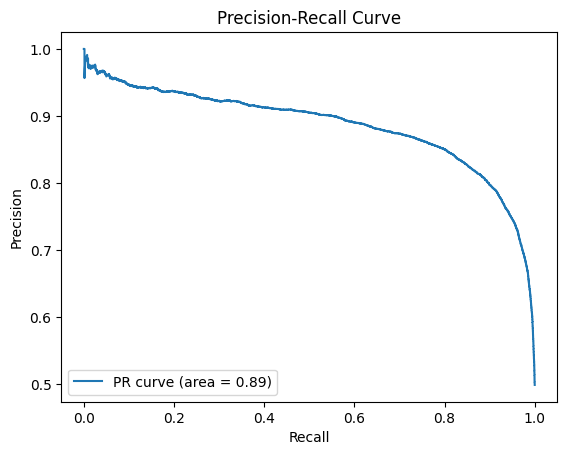

In [ ]:
logreg = LogReg(gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2)

logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Интерпретация результатов
ROC-AUC и PRC оказались достаточно высокими - это говорит о хорошем качестве модели, также стоит отметить, что т.к. ROC-AUC не сильно отличается от PRC, можно сделать вывод, что в данных нет дизбаланса классов



# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [6]:
PATH_TO_DATASET = '/content/train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
# В чате разрешили работать с подвыборкой 20000 чтобы не ждать обучение очень долго
data = data.sample(n=20000, random_state=124)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [ ]:
data.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1149576,4,2,0,1,-1,0,1,0,0,0,...,10,2,7,5,0,0,1,0,0,0
1022505,0,1,5,0,0,1,0,0,0,0,...,4,3,2,7,0,1,0,0,0,1
451220,0,1,5,0,0,1,0,0,0,0,...,7,4,2,7,0,0,0,1,0,1
387700,4,1,9,0,0,0,0,0,1,0,...,4,1,5,4,0,0,1,1,0,0
835896,0,2,1,0,0,0,0,1,0,0,...,5,2,1,7,0,1,1,0,0,1


In [ ]:
data.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,...,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.920500,1.358350,4.41745,0.421650,0.405250,0.392800,0.260150,0.160300,0.18675,0.000150,...,5.443750,1.441100,2.85295,7.533350,0.119850,0.627800,0.552700,0.290000,0.351700,0.154100
std,1.985416,0.669894,2.69786,0.494544,1.349301,0.488385,0.438727,0.366893,0.38972,0.012247,...,2.340451,1.199209,1.69073,2.744861,0.324794,0.483403,0.497227,0.453773,0.477513,0.361054
min,0.000000,-1.000000,0.00000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,4.000000,1.000000,2.00000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,5.000000,1.000000,3.00000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,6.00000,1.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,7.000000,2.000000,4.00000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,7.000000,4.000000,11.00000,1.000000,6.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,17.000000,8.000000,11.00000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1149576 to 1242465
Data columns (total 57 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ps_ind_01       20000 non-null  int64  
 1   ps_ind_02_cat   20000 non-null  int64  
 2   ps_ind_03       20000 non-null  int64  
 3   ps_ind_04_cat   20000 non-null  int64  
 4   ps_ind_05_cat   20000 non-null  int64  
 5   ps_ind_06_bin   20000 non-null  int64  
 6   ps_ind_07_bin   20000 non-null  int64  
 7   ps_ind_08_bin   20000 non-null  int64  
 8   ps_ind_09_bin   20000 non-null  int64  
 9   ps_ind_10_bin   20000 non-null  int64  
 10  ps_ind_11_bin   20000 non-null  int64  
 11  ps_ind_12_bin   20000 non-null  int64  
 12  ps_ind_13_bin   20000 non-null  int64  
 13  ps_ind_14       20000 non-null  int64  
 14  ps_ind_15       20000 non-null  int64  
 15  ps_ind_16_bin   20000 non-null  int64  
 16  ps_ind_17_bin   20000 non-null  int64  
 17  ps_ind_18_bin   20000 non-nu

In [ ]:
y_train.shape

(16000,)

In [ ]:
X_train.shape

(16000, 57)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [10]:
from sklearn.preprocessing import OneHotEncoder

cat_columns = [col for col in data.columns if col.endswith('_cat')]

encoder = OneHotEncoder(sparse_output=False)
encoded_train = encoder.fit_transform(X_train[cat_columns])
encoded_test = encoder.transform(X_test[cat_columns])

X_train_encoded = pd.DataFrame(encoded_train,
                                columns=encoder.get_feature_names_out(cat_columns),
                                index=X_train.index)
X_test_encoded = pd.DataFrame(encoded_test,
                               columns=encoder.get_feature_names_out(cat_columns),
                               index=X_test.index)

X_train = pd.concat([X_train.drop(columns=cat_columns), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_columns), X_test_encoded], axis=1)

print(X_train.shape)

(16000, 226)


Фиксирую что получилось 227 признаков, было 57

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [ ]:
# !pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
import time
from sklearn.preprocessing import StandardScaler

# Логистическая регрессия

In [ ]:
lr_params = {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}
start_time = time.time()
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, scoring='roc_auc', cv=3)
lr_grid.fit(X_train, y_train)
lr_grid_time = time.time() - start_time
lr_best_auc = roc_auc_score(y_test, lr_grid.best_estimator_.predict_proba(X_test)[:, 1])
print(f'Лучшие параметры: {lr_grid.best_params_}')
print(lr_grid_time, lr_best_auc)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Лучшие параметры: {'C': 0.1, 'class_weight': None}
91.0052056312561 0.6018565034709537


# SVC

In [ ]:
svm_params = {'C': [0.1, 1, 10], 'class_weight': [None, 'balanced']}
start_time = time.time()
svm_grid = GridSearchCV(SVC(probability=True, kernel='rbf', random_state=124), svm_params, scoring='roc_auc', cv=2, n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_grid_time = time.time() - start_time
svm_best_auc = roc_auc_score(y_test, svm_grid.best_estimator_.predict_proba(X_test)[:, 1])
print(f'Лучшие параметры: {svm_grid.best_params_}')
print(svm_grid_time, svm_best_auc)

Лучшие параметры: {'C': 0.1, 'class_weight': 'balanced'}
713.2218024730682 0.5842372794966012


# Метод k ближайших соседей

In [ ]:
knn_params = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
start_time = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, scoring='roc_auc', cv=3, n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_grid_time = time.time() - start_time
knn_best_auc = roc_auc_score(y_test, knn_grid.best_estimator_.predict_proba(X_test)[:, 1])
print(f'Лучшие параметры: {knn_grid.best_params_}')
print(knn_grid_time, knn_best_auc)

Лучшие параметры: {'n_neighbors': 10, 'weights': 'uniform'}
22.879571676254272 0.533272632634117


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [ ]:
start_time = time.time()
lr = LogisticRegression(max_iter=1000, random_state=42, C=0.1)
lr.fit(X_train, y_train)
training_time = time.time() - start_time
print(f'Обучение модели на изначальных признаках: {training_time}')

feature_weights = np.abs(lr.coef_[0])

best_feats = np.argsort(feature_weights)[-150:][::-1]

X_train_best_feats = X_train.iloc[:, best_feats]
X_test_best_feats = X_test.iloc[:, best_feats]

non_categorical_columns = [col for col in X_train_best_feats.columns if not col.endswith('_cat') and not col.endswith('_bin')]

print(f'Фиксирую, что масштабировать нужно {non_categorical_columns} признаков')

scaler = StandardScaler()
X_train_best_feats[non_categorical_columns] = scaler.fit_transform(X_train_best_feats[non_categorical_columns])
X_test_best_feats[non_categorical_columns] = scaler.transform(X_test_best_feats[non_categorical_columns])


start_time = time.time()
lr_best_feats = LogisticRegression(max_iter=1000, random_state=42, C=0.1)
lr_best_feats.fit(X_train_best_feats, y_train)
training_time2 = time.time() - start_time
print(f'Обучение модели на 150 признаках: {training_time2}')

y_pred_best_feats = lr_best_feats.predict_proba(X_test_best_feats)[:, 1]
roc_auc_best_feats = roc_auc_score(y_test, y_pred_best_feats)
print(f'ROC-AUC на тестовой выборке: {roc_auc_best_feats}')
print(f'Разница во времени: {training_time2 - training_time}')

Обучение модели на изначальных признаках: 1.428175687789917
Фиксирую, что масштабировать нужно ['ps_ind_05_cat_0', 'ps_ind_02_cat_3', 'ps_car_04_cat_2.0', 'ps_ind_05_cat_2', 'ps_ind_04_cat_-1', 'ps_car_06_cat_9.0', 'ps_car_11_cat_45.0', 'ps_car_01_cat_-1.0', 'ps_car_09_cat_-1.0', 'ps_car_11_cat_87.0', 'ps_car_09_cat_3.0', 'ps_ind_02_cat_-1', 'ps_car_01_cat_7.0', 'ps_car_11_cat_9.0', 'ps_car_01_cat_8.0', 'ps_ind_02_cat_4', 'ps_car_06_cat_5.0', 'ps_car_06_cat_17.0', 'ps_car_09_cat_0.0', 'ps_car_11_cat_12.0', 'ps_ind_05_cat_4', 'ps_car_11_cat_1.0', 'ps_car_09_cat_4.0', 'ps_car_11_cat_92.0', 'ps_car_11_cat_7.0', 'ps_car_11_cat_40.0', 'ps_car_06_cat_16.0', 'ps_car_03_cat_1.0', 'ps_car_06_cat_7.0', 'ps_ind_04_cat_0', 'ps_ind_05_cat_1', 'ps_car_09_cat_2.0', 'ps_car_09_cat_1.0', 'ps_car_11_cat_102.0', 'ps_car_11_cat_93.0', 'ps_car_11_cat_50.0', 'ps_car_06_cat_13.0', 'ps_car_11_cat_49.0', 'ps_car_11_cat_42.0', 'ps_car_11_cat_41.0', 'ps_car_11_cat_65.0', 'ps_car_06_cat_4.0', 'ps_car_01_cat_4.0',

<ipython-input-21-65fca044a218>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_best_feats[non_categorical_columns] = scaler.fit_transform(X_train_best_feats[non_categorical_columns])
<ipython-input-21-65fca044a218>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_best_feats[non_categorical_columns] = scaler.transform(X_test_best_feats[non_categorical_columns])


Кавество стало хуже, но модель обучается быстрее

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [ ]:
# Отбор 200 признак
lr = LogisticRegression(max_iter=1000, random_state=124, C=0.1)
lr.fit(X_train, y_train)

feature_weights = np.abs(lr.coef_[0])
top_200 = np.argsort(feature_weights)[-200:][::-1]

X_train_top200 = X_train.iloc[:, top_200]
X_test_top200 = X_test.iloc[:, top_200]

print(f"Отобрано 200 признаков. Размер X_train: {X_train_top200.shape}")

# Отбор 150 признаков
lr_top200 = LogisticRegression(max_iter=1000, random_state=124, C=0.1)
lr_top200.fit(X_train_top200, y_train)

feature_weights_top200 = np.abs(lr_top200.coef_[0])
top_150 = np.argsort(feature_weights_top200)[-150:][::-1]

X_train_top150 = X_train_top200.iloc[:, top_150]
X_test_top150 = X_test_top200.iloc[:, top_150]

# Обучение модели на отобранных признаках
lr_top150 = LogisticRegression(max_iter=1000, random_state=124, C=0.1)
lr_top150.fit(X_train_top150, y_train)
y_pred_top150 = lr_top150.predict_proba(X_test_top150)[:, 1]
roc_auc_best_feats = roc_auc_score(y_test, y_pred_top150)
print(f'ROC-AUC на тестовой выборке: {roc_auc_best_feats}')

Отобрано 200 признаков. Размер X_train: (16000, 200)
ROC-AUC на тестовой выборке: 0.5804963865321675


Так качество стало чуть лучше, чем когда мы отобрали сразу 150

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [7]:
data = pd.read_csv(PATH_TO_DATASET, index_col=0)
# Сделал выборку побольше, потомучто на 20000 объектах после L1 регуляризации остается лишь 9 признаков
data = data.sample(n=100000, random_state=124)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)
from sklearn.preprocessing import OneHotEncoder

cat_columns = [col for col in data.columns if col.endswith('_cat')]

encoder = OneHotEncoder(sparse_output=False)
encoded_train = encoder.fit_transform(X_train[cat_columns])
encoded_test = encoder.transform(X_test[cat_columns])

X_train_encoded = pd.DataFrame(encoded_train,
                                columns=encoder.get_feature_names_out(cat_columns),
                                index=X_train.index)
X_test_encoded = pd.DataFrame(encoded_test,
                               columns=encoder.get_feature_names_out(cat_columns),
                               index=X_test.index)

X_train = pd.concat([X_train.drop(columns=cat_columns), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_columns), X_test_encoded], axis=1)

print(X_train.shape)

(80000, 227)


In [8]:
lr_params_grid = {
    'C': [0.1, 1, 4]
}
lr_grid = GridSearchCV(LogisticRegression(solver='liblinear', penalty='l1', random_state=124), lr_params_grid, cv=2, n_jobs=-1)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=LogisticRegression(penalty='l1', random_state=124,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 4]})

In [10]:
linreg = lr_grid.best_estimator_

nonzero_weights = np.sum(linreg.coef_ != 0)
print(f'Количество ненулевых весов: {nonzero_weights}')

nonzero_rounded_weights = np.sum(np.round(linreg.coef_, 2) != 0 )
print(f'Количество ненулевых весов после округления: {nonzero_rounded_weights}')

Количество ненулевых весов: 181
Количество ненулевых весов после округления: 174


In [13]:
roc_auc_best_feats = roc_auc_score(y_test, linreg.predict(X_test))
print(f'ROC-AUC на тестовой выборке: {roc_auc_best_feats}')

ROC-AUC на тестовой выборке: 0.5638094279733838


не удалось, но я был близок

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [17]:
non_cat_bin_columns = [col for col in X_train.columns if not col.endswith('_cat') and not col.endswith('_bin')]
print(f'Выделяю непрерывные признкаи: {non_cat_bin_columns}')

scaler = StandardScaler()
X_train[non_cat_bin_columns] = scaler.fit_transform(X_train[non_cat_bin_columns])
X_test[non_cat_bin_columns] = scaler.transform(X_test[non_cat_bin_columns])

t_stats = {}

start = time.time()
for feature in non_cat_bin_columns:
  mean_pos = X_train[y_train == 1][feature].mean()
  mean_neg = X_train[y_train == 0][feature].mean()
  std_pos = X_train[y_train == 1][feature].std()
  std_neg = X_train[y_train == 0][feature].std()
  n_pos = len(X_train[y_train == 1])
  n_neg = len(X_train[y_train == 0])

  t_stat = abs(mean_pos - mean_neg) / np.sqrt((n_pos * std_pos**2 + n_neg * std_neg**2) / (n_pos + n_neg))
  t_stats[feature] = t_stat

top_features = sorted(t_stats, key=t_stats.get, reverse=True)
selected_features = top_features[:len(top_features) // 2]

categorical_binary_columns = [col for col in X_train.columns if col.endswith('_cat') or col.endswith('_bin')]
final_features = selected_features + categorical_binary_columns
print(f'Время отбора признаков: {time.time() - start}')

model = LogisticRegression()
model.fit(X_train[final_features], y_train)

y_pred = model.predict(X_test[final_features])

roc_auc_best_feats = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC на тестовой выборке: {roc_auc_best_feats}')

Выделяю непрерывные признкаи: ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_ind_02_cat_-1', 'ps_ind_02_cat_1', 'ps_ind_02_cat_2', 'ps_ind_02_cat_3', 'ps_ind_02_cat_4', 'ps_ind_04_cat_-1', 'ps_ind_04_cat_0', 'ps_ind_04_cat_1', 'ps_ind_05_cat_-1', 'ps_ind_05_cat_0', 'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3', 'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'ps_car_01_cat_-1', 'ps_car_01_cat_0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_01_cat_3', 'ps_car_01_cat_4', 'ps_car_01_cat_5', 'ps_car_01_cat_6', 'ps_car_01_cat_7', 'ps_car_01_cat_8', 'ps_car_01_cat_9', 'ps_car_01_cat_10', 'ps_car_01_cat_11', 'ps_car_02_cat_-1', 'ps_car_02_cat_0', 'ps_car_02_cat_1', 'p

### **Методы-обёртки**

### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

Мы использвоали несколько методов отбора признаков

1) Просто отобрали 150 наибольших признаков и получили ROC-AUC на тестовой выборке: 0.56

Плюсы: Скорость, выбрать 150 наибольших значений из массива признаков очень легко


Минусы: Не лучшая точность


2) Итеративно отобрали сначала 200 и потом 150 и получили ROC-AUC на тестовой выборке: 0.58

Плюсы: Самая лучшая точность


Минусы: Выполняется дольше, чем 1 и 3 метод


3) Воспользовались "встроенными" методами, отобрали признак с L1 регуляризацией и просто ниже определённой точности
ROC-AUC на тестовой выборке: 0.56

Плюсы: Встроенный метод, не нужно добавлять в пайплайн лишних действий, показывает +- такую же точность как 1 метод, так что можно заменить его данным


Минусы: Не лучшая точность


4) Посчитали t-статистику ROC-AUC на тестовой выборке: 0.500629316416029
Плюсы: Если честно, не нашел


Минусы: Очень долго отбирает признаки, также имеет худшую точность

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [51]:
from sklearn.model_selection import train_test_split

PATH = '/content/train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [52]:
gaps = data.isnull().sum()

data = data.fillna('')

print(gaps)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [53]:
gaps = data.isnull().sum()

print(gaps)

id          0
keyword     0
location    0
text        0
target      0
dtype: int64


- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [54]:
print(data.select_dtypes(include=['number']).nunique())

id        7613
target       2
dtype: int64


- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [55]:
class_counts = data['target'].value_counts()

print("Количество записей для каждого класса:")
print(class_counts)

Количество записей для каждого класса:
target
0    4342
1    3271
Name: count, dtype: int64


В нашем случае классом почти поровну
Это важно учитывать т.к. дисбаланс количества классов может усложнить задачу
Также подбор метрики зависит от балансировки классов, например roc-auc или accuracy не подошли бы, если бы у нас был сильный дисбаланс классов

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [56]:
data['text'] = data[['keyword', 'location', 'text']].agg(' '.join, axis=1)
data.drop(columns=['keyword', 'location'], inplace=True)
data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' ar...,1
3,6,"13,000 people receive #wildfires evacuation ...",1
4,7,Just got sent this photo from Ruby #Alaska a...,1


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [57]:
target = data.target.values

data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=124)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text'])
X_test_vec = vectorizer.transform(X_test['text'])
X_train_vec.shape

(5329, 18392)

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [84]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

In [79]:
lr = LogisticRegression(random_state=142)
start = time.time()
lr.fit(X_train_vec, y_train)
print(f'Время обучения: {time.time() - start}')
lr_f1_score = f1_score(y_test, lr.predict(X_test_vec))
print(f'f1-score: {lr_f1_score}')

Время обучения: 0.8240146636962891
f1-score: 0.7602339181286549


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [78]:
svc_model = SVC(random_state=142)
start = time.time()
svc_model.fit(X_train_vec, y_train)
print(f'Время обучения SVC: {time.time() - start}')
svc_f1_score = f1_score(y_test, svc_model.predict(X_test_vec))
print(f'f1-score: {svc_f1_score}')

Время обучения SVC: 5.34598708152771
f1-score: 0.7481439177612793


Время обучения оказалось дольше, а результат хуже

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [82]:
FEATURE_LIMIT = len(X_train) // 4

In [102]:
param_grid = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_features': [FEATURE_LIMIT - 2, FEATURE_LIMIT - 1, FEATURE_LIMIT]
}

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train['text'], y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

y_test_pred = grid_search.best_estimator_.predict(X_test['text'])
test_accuracy = f1_score(y_test, y_test_pred)

print("Лучшие параметры:", best_params)
print("Количество признаков после настройки:", grid_search.best_estimator_['vectorizer'].fit_transform(X_train['text']).shape[1])
print("Качество на тестовых данных:", test_accuracy)

if grid_search.best_estimator_['vectorizer'].fit_transform(X_train['text']).shape[1] <= FEATURE_LIMIT and abs(test_accuracy - lr_f1_score) <= 0.07:
    print("Условие выполнено: признаки уменьшены в 4 раза, потеря качества не превышает 0.07.")
else:
    print("Условие не выполнено.")

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Лучшие параметры: {'vectorizer__max_df': 0.8, 'vectorizer__max_features': 1330, 'vectorizer__min_df': 2}
Количество признаков после настройки: 1330
Качество на тестовых данных: 0.7485442032821599
Условие выполнено: признаки уменьшены в 4 раза, потеря качества не превышает 0.07.


In [103]:
param_grid = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_features': [FEATURE_LIMIT - 2, FEATURE_LIMIT - 1, FEATURE_LIMIT]
}

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC())
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train['text'], y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

y_test_pred = grid_search.best_estimator_.predict(X_test['text'])
test_accuracy = f1_score(y_test, y_test_pred)

print("Лучшие параметры:", best_params)
print("Количество признаков после настройки:", grid_search.best_estimator_['vectorizer'].fit_transform(X_train['text']).shape[1])
print("Качество на тестовых данных:", test_accuracy)

if grid_search.best_estimator_['vectorizer'].fit_transform(X_train['text']).shape[1] <= FEATURE_LIMIT and abs(test_accuracy - svc_f1_score) <= 0.07:
    print("Условие выполнено: признаки уменьшены в 4 раза, потеря качества не превышает 0.07.")
else:
    print("Условие не выполнено.")

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Лучшие параметры: {'vectorizer__max_df': 0.8, 'vectorizer__max_features': 1332, 'vectorizer__min_df': 1}
Количество признаков после настройки: 1332
Качество на тестовых данных: 0.7474633596392334
Условие выполнено: признаки уменьшены в 4 раза, потеря качества не превышает 0.07.


Гридсерчем подобрали параметры
max_df - определяет максимальный процент документов, которые могут содержать слово чтобы оно считалось информативным. Чем больше гиперпараметр - тем больше признаков

Если слово слишком часто встречается в документе, скорее всего это какой-нибудь союз типа and, the.. и им можно принебречь


max_features - Простое ограничение общего количества слов в словаре, выбирает наиболее частотные. Чем больше гиперпараметр - тем больше признаков


min_df -  то же, что и max_df, но определяет минимальное КОЛИЧЕСТВО документов, в которых должно появиться слово. В нашем случае один документ = один объект. Чем больше гиперпараметр - тем меньше признаков

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [115]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(C=0.1, random_state=124))
])

grid_params = {'classifier__penalty': ['l1', 'l2'],
               'classifier__solver': ['liblinear', 'saga'],
               'classifier__max_iter': [1000, 2000, 3000]
               }

grid_search = GridSearchCV(
    pipeline,
    grid_params,
    cv=2,
    scoring='f1',
    verbose=1
)
grid_search.fit(X_train['text'], y_train)
lr_best_f1 = f1_score(y_test, grid_search.best_estimator_.predict(X_test['text']))
print(f'Лучшие параметры: {grid_search.best_params_}')
print(lr_best_f1)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Лучшие параметры: {'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
0.761437908496732


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [116]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC(max_iter=1000, random_state=124))
])

grid_params = {'classifier__C': [0.1, 1, 10],
               'classifier__kernel': ['linear', 'rbf']
               }

grid_search = GridSearchCV(
    pipeline,
    grid_params,
    cv=2,
    scoring='f1',
    verbose=1
)
grid_search.fit(X_train['text'], y_train)
svc_best_f1 = f1_score(y_test, grid_search.best_estimator_.predict(X_test['text']))
print(f'Лучшие параметры: {grid_search.best_params_}')
print(svc_best_f1)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

Лучшие параметры: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
0.721881390593047


LogisticRegression:


penalty - регуляризатор
solver - функция минимизации ошибки
max_iter - максимальное количество итераций


Лучшие параметры: {'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


SVC:
С - параметр жесткости регуляризации
kernel - тип преобразования признаков


Лучшие параметры: {'classifier__C': 10, 'classifier__kernel': 'rbf'}



### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [118]:
# LogisticRegression
lr_param_grid = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_features': [FEATURE_LIMIT - 2, FEATURE_LIMIT - 1, FEATURE_LIMIT],
    'classifier__C': [0.1, 1, 10]
}

lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=3,
    scoring='f1',
    verbose=1
)

lr_grid_search.fit(X_train['text'], y_train)
lr_best_params = lr_grid_search.best_params_
lr_y_test_pred = lr_grid_search.best_estimator_.predict(X_test['text'])
lr_test_f1 = f1_score(y_test, lr_y_test_pred)

print("Логистическая регрессия:")
print("Лучшие параметры:", lr_best_params)
print("F1-метрика на тестовых данных:", lr_test_f1)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Логистическая регрессия:
Лучшие параметры: {'classifier__C': 0.1, 'vectorizer__max_df': 0.8, 'vectorizer__max_features': 1331, 'vectorizer__min_df': 1}
F1-метрика на тестовых данных: 0.7537026878771256


In [ ]:
# SVC

svc_param_grid = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__min_df': [1, 2],
    'vectorizer__max_features': [FEATURE_LIMIT - 2, FEATURE_LIMIT - 1, FEATURE_LIMIT],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

svc_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC(C=0.1, random_state=42))
])

svc_grid_search = GridSearchCV(
    svc_pipeline,
    svc_param_grid,
    cv=2,
    scoring='f1',
    verbose=1
)

svc_grid_search.fit(X_train['text'], y_train)
svc_best_param = svc_grid_search.best_params_
svc_y_test_pred = svc_grid_search.best_estimator_.predict(X_test['text'])
svc_test_f1 = f1_score(y_test, svc_y_test_pred)

print("\nSVC:")
print("Лучшие параметры:", svc_best_param)
print("F1-метрика на тестовых данных:", svc_test_f1)


Fitting 2 folds for each of 48 candidates, totalling 96 fits


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

In [64]:
Поработали с классификаторами, написали свою логистическую регрессию и посмотрели на то как работают классификаторы на больших данных (И НАСКОЛЬКО ЭТО ДОЛГО)

Большая часть работы была выделена на отбор параметров - важный этап в обучении моделей, т.к. уменьшяет затрачиваемое время на обучение путем выделения только самых значимых параметров

## Чей кот?

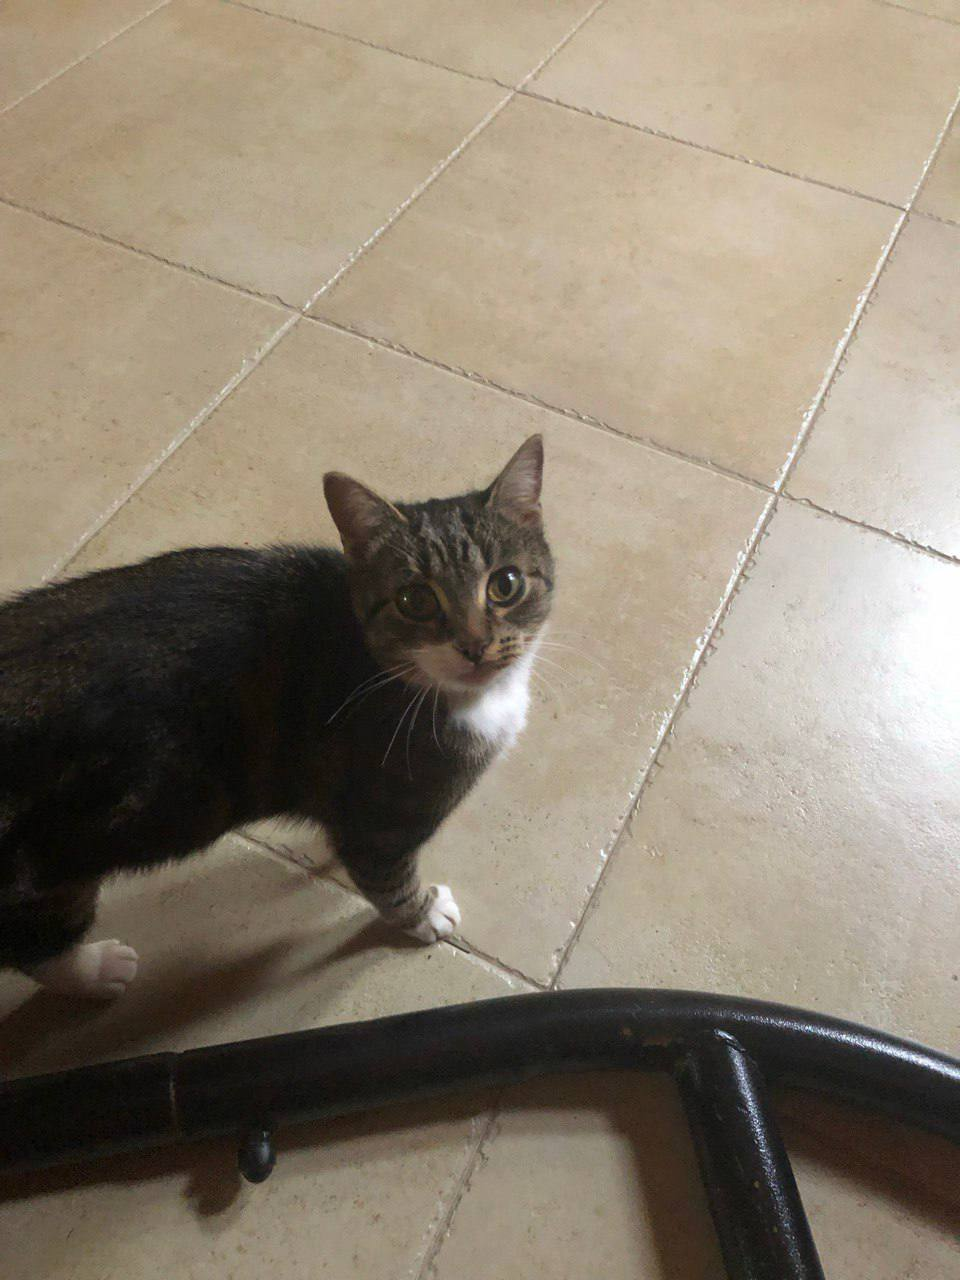

Пусть будет @malyushitsky